In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import math

data = pd.read_csv('LABS-LAGGED.csv')
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y-%m-%d')
data.set_index('Timestamp', inplace=True)

# Convert DayOfWeek to radians
data['t'] = (data['DayOfWeek'] / 6) * 2 * np.pi

d = 2
z = d+1
# Calculate sine and cosine values for multiple angles
angle_cols = []
for i in range(1, z):  # 1 to z
    angle = i * data['t']
    angle_cols.append(pd.Series(np.sin(angle), name=f'sin({i}t)'))
    angle_cols.append(pd.Series(np.cos(angle), name=f'cos({i}t)'))

# Concatenate all angle columns to the DataFrame
data = pd.concat([data] + angle_cols, axis=1)

data.drop(columns=['DayOfWeek','t','HSW-COD-load','HSW-COD-load_1', 'HSW-COD-load_2', 'HSW-COD-load_3', 'HSW-COD-load_4',
                  'HSW-COD-load_5', 'HSW-COD-load_6', 'Dig-stability', 'Biogas_6', 'TWAS-VS-load_2', 'PS-VS-load_3'
                  , 'PS-VS-load_5', 'PS-VS-load_6', 'TWAS-VS-load_4','TWAS-VS-load_3','SRT','PS-VS-load_1','HSW-VS-load_2'
                  , 'Biogas_4','HSW-VS-load_5','PS-VS-load','Biogas_3','PS-VS-load_2','TWAS-VS-load_5','TWAS-VS-load_6'
                  , 'PS-VS-load_4', 'Biogas_2','HSW-VS-load_3','HSW-VS-load_4','TWAS-VS-load','TWAS-VS-load_1','BOD-load'], inplace=True)


# Check the last few features
print(data.iloc[:, -7:])
data.columns

            HSW-VS-load_6  Biogas_1  Biogas_5       sin(1t)  cos(1t)  \
Timestamp                                                              
2020-01-07           0.00      57.8      62.8  8.660254e-01      0.5   
2020-01-08           0.00      37.3      53.0  8.660254e-01     -0.5   
2020-01-09           0.00      50.7      41.9  1.224647e-16     -1.0   
2020-01-10           0.00      48.2      32.5 -8.660254e-01     -0.5   
2020-01-11           0.00      56.2      57.8 -8.660254e-01      0.5   
...                   ...       ...       ...           ...      ...   
2023-03-26      112968.75      84.0     126.8 -2.449294e-16      1.0   
2023-03-27       78643.66      72.1     107.2  0.000000e+00      1.0   
2023-03-28       75094.80      75.2      88.1  8.660254e-01      0.5   
2023-03-29       17789.80      83.3      98.5  8.660254e-01     -0.5   
2023-03-30       99599.90      93.6      84.0  1.224647e-16     -1.0   

                 sin(2t)  cos(2t)  
Timestamp                  

Index(['Biogas', 'HSW-VS-load', 'Forecast', 'HSW-VS-load_1', 'HSW-VS-load_6',
       'Biogas_1', 'Biogas_5', 'sin(1t)', 'cos(1t)', 'sin(2t)', 'cos(2t)'],
      dtype='object')

In [2]:
#import seaborn as sns
#sns.pairplot(data)
#fig, ax = plt.subplots(figsize=(15, 7.5))
#sns.heatmap(data.corr(method='spearman'), annot=True, cmap = 'viridis')

In [3]:
from sklearn.preprocessing import RobustScaler, StandardScaler

x_train, x_test, y_train, y_test = train_test_split(
    data.drop('Forecast', axis=1), data['Forecast'], test_size=0.2,
    shuffle=False)

# Initialize scaler object
scaler = StandardScaler()
z2=z-1
# Fit the scaler on the training dataset, but we have to exclude the sine and cosine terms
scaler.fit(x_train.iloc[:, :-z2])

# Transform the training and testing dataset
x_train_s = pd.DataFrame(scaler.transform(x_train.iloc[:, :-z2]), index=x_train.index)
x_test_s = pd.DataFrame(scaler.transform(x_test.iloc[:, :-z2]), index=x_test.index)

# Combine sine and cosine terms
x_train_s = pd.concat([x_train_s, x_train.iloc[:, -z2:]], axis=1, ignore_index=True)
x_test_s = pd.concat([x_test_s, x_test.iloc[:, -z2:]], axis=1, ignore_index=True)

# Add the column names back
x_train_s.columns = x_train.columns
x_test_s.columns = x_test.columns

# Check to make sure everything looks right
x_train_s

,Biogas,HSW-VS-load,HSW-VS-load_1,HSW-VS-load_6,Biogas_1,Biogas_5,sin(1t),cos(1t),sin(2t),cos(2t)
Timestamp,,,,,,,,,,
2020-01-07,-1.546131,-1.165609,-1.161616,-1.139907,-1.041926,-0.900309,1.319465,0.480431,8.660254e-01,-0.5
2020-01-08,-1.219688,-1.165609,-1.161616,-1.139907,-1.540460,-1.137155,1.319465,-0.867251,-8.660254e-01,-0.5
2020-01-09,-1.280591,-1.165609,-1.161616,-1.139907,-1.214589,-1.405420,-0.003037,-1.541091,-2.449294e-16,1.0
2020-01-10,-1.085700,-1.165609,-1.161616,-1.139907,-1.275386,-1.632599,-1.325539,-0.867251,8.660254e-01,-0.5
2020-01-11,-1.073519,-1.165609,-1.161616,-1.139907,-1.080836,-1.021149,-1.325539,0.480431,-8.660254e-01,-0.5
...,...,...,...,...,...,...,...,...,...,...
2022-08-20,0.103137,0.416764,0.423844,-0.398416,0.538789,-0.105182,-1.325539,0.480431,-8.660254e-01,-0.5
2022-08-21,-0.722715,0.014252,0.418684,0.615089,0.105916,0.428931,-0.003037,1.154271,-4.898587e-16,1.0
2022-08-22,-0.384091,1.109677,0.016700,1.290171,-0.718488,0.513519,-0.003037,1.154271,0.000000e+00,1.0


In [4]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

column_names = x_train.columns  
columns_to_drop = ['SRT', 'Biogas', 'Dig-stability', 'HSW-VS-load', 'HSW-COD-load',
       'TWAS-VS-load', 'PS-VS-load', 'BOD-load', 'Forecast',
       'HSW-COD-load_1', 'HSW-COD-load_2', 'HSW-COD-load_3', 'HSW-COD-load_4',
       'HSW-COD-load_5', 'HSW-COD-load_6', 'HSW-VS-load_1', 'HSW-VS-load_2',
       'HSW-VS-load_3', 'HSW-VS-load_4', 'HSW-VS-load_5', 'HSW-VS-load_6',
       'PS-VS-load_1', 'PS-VS-load_2', 'PS-VS-load_3', 'PS-VS-load_4',
       'PS-VS-load_5', 'PS-VS-load_6', 'TWAS-VS-load_1', 'TWAS-VS-load_2',
       'TWAS-VS-load_3', 'TWAS-VS-load_4', 'TWAS-VS-load_5', 'TWAS-VS-load_6',
       'Biogas_1', 'Biogas_2', 'Biogas_3', 'Biogas_4', 'Biogas_5', 'Biogas_6']  # List of column names to be dropped

# Drop the specified non-periodic columns
diurnal_cols = [col for col in column_names if col not in columns_to_drop]
cv=TimeSeriesSplit(gap = 5)
model_lm_per = RidgeCV(cv=cv) 
model_lm_per.fit(x_train_s, y_train)

# Predict using the fitted model
y_train_lm_per = model_lm_per.predict(x_train_s)
y_test_lm_per = model_lm_per.predict(x_test_s)

# Calculate training and testing error
mse_train_lm_per = mean_squared_error(y_train, y_train_lm_per)
r2_train_lm_per = r2_score(y_train, y_train_lm_per)
mse_test_lm_per = mean_squared_error(y_test, y_test_lm_per)
r2_test_lm_per = r2_score(y_test, y_test_lm_per)

# Print training and testing error
print(f"Training Mean Squared Error (MSE): {round(mse_train_lm_per,3)}")
print(f"Training R-squared (R2) Score: {round(r2_train_lm_per,3)}")
print(f"Testing Mean Squared Error (MSE): {round(mse_test_lm_per,3)}")
print(f"Testing R-squared (R2) Score: {round(r2_test_lm_per,3)}")

Training Mean Squared Error (MSE): 453.06
Training R-squared (R2) Score: 0.73
Testing Mean Squared Error (MSE): 552.563
Testing R-squared (R2) Score: 0.647


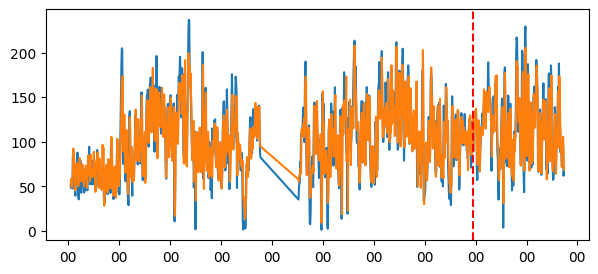

In [5]:
import matplotlib.dates as mdates
fig = plt.figure(figsize=(7, 3))
x =  data.index
y1 = data['Forecast'] # Forecast
y2 = np.concatenate((y_train_lm_per, y_test_lm_per))
v = data.index[y_train_lm_per.shape[0]]
plt.plot(x, y1, label='actual')
plt.plot(x, y2, label='diurnal')
plt.axvline(x=v, color='r', linestyle='--')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M'))
plt.show()

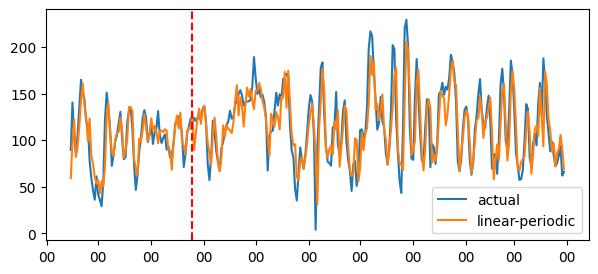

In [6]:
fig = plt.figure(figsize=(7, 3))

# Define the desired index range
start_index = 800
end_index = 1100

x = data.index[start_index:end_index]
y1 = data['Forecast'][start_index:end_index]  # Forecast
y2 = np.concatenate((y_train_lm_per, y_test_lm_per))[start_index:end_index]

v = data.index[y_train_lm_per.shape[0]]  # Adjust the index for v

plt.plot(x, y1, label='actual')
plt.plot(x, y2, label='linear-periodic')
plt.axvline(x=v, color='r', linestyle='--')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M'))
plt.legend()
plt.show()


In [7]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import RidgeCV

model_lm = RidgeCV(cv=cv) 

# Select all but the periodic columns
no_diurnal_cols = ~x_train_s.columns.isin(diurnal_cols)

model_lm.fit(x_train_s.loc[:, no_diurnal_cols], y_train)

# Predict using the fitted model
y_train_lm = model_lm.predict(x_train_s.loc[:, no_diurnal_cols])
y_test_lm = model_lm.predict(x_test_s.loc[:, no_diurnal_cols])

# Calculate training and testing error
mse_train_lm = mean_squared_error(y_train, y_train_lm)
mape_train_lm = mean_absolute_percentage_error(y_train, y_train_lm)
r2_train_lm = r2_score(y_train, y_train_lm)
rmse_train = math.sqrt(mse_train_lm)
mse_test_lm = mean_squared_error(y_test, y_test_lm)
mape_test_lm = mean_absolute_percentage_error(y_test, y_test_lm)
r2_test_lm = r2_score(y_test, y_test_lm)
rmse_test = math.sqrt(mse_test_lm)

# Print training and testing error
print(f"Training Mean Squared Error (MSE): {round(mse_train_lm,3)}")
print(f"Training Root Mean Squared Error (MSE): {round(rmse_train,3)}")
print(f"Training Mean Absolute Percentage Error (MAPE): {round(mape_train_lm,3)}")
print(f"Training R-squared (R2) Score: {round(r2_train_lm,3)}")
print(f"Testing Mean Squared Error (MSE): {round(mse_test_lm,3)}")
print(f"Testing Root Mean Squared Error (MSE): {round(rmse_test,3)}")
print(f"Testing Mean Absolute Percentage Error (MAPE): {round(mape_test_lm,3)}")
print(f"Testing R-squared (R2) Score: {round(r2_test_lm,3)}")

def adjusted_r2(r2, n, k):
    return 1 - ((1 - r2) * (n - 1)) / (n - k - 1)

n = len(x_test_s)  # Number of samples in test data
k = len(x_train_s.columns)-2*d  # Number of predictors in the model

# Calculate Adjusted R-squared
adjusted_r2_value = adjusted_r2(r2_test_lm, n, k)
print("Adjusted R-squared:", round(adjusted_r2_value,3))
print("Number of variables:",k)
TeEI = (mape_test_lm*mape_test_lm*rmse_test)/adjusted_r2_value
print("TeEI:", round(TeEI,3))

Training Mean Squared Error (MSE): 501.77
Training Root Mean Squared Error (MSE): 22.4
Training Mean Absolute Percentage Error (MAPE): 0.348
Training R-squared (R2) Score: 0.701
Testing Mean Squared Error (MSE): 589.715
Testing Root Mean Squared Error (MSE): 24.284
Testing Mean Absolute Percentage Error (MAPE): 0.276
Testing R-squared (R2) Score: 0.623
Adjusted R-squared: 0.613
Number of variables: 6
TEI: 3.025


In [8]:
from regressors import stats
p = stats.coef_pval(model_lm, x_train_s.loc[:, no_diurnal_cols], y_train)
c = x_train_s.loc[:, no_diurnal_cols][:0]
p=np.around(p, decimals=3, out=None)
print(c)
print(p)

Empty DataFrame
Columns: [Biogas, HSW-VS-load, HSW-VS-load_1, HSW-VS-load_6, Biogas_1, Biogas_5]
Index: []
[0.    0.    0.    0.    0.007 0.002 0.001]


In [9]:
stats.summary(model_lm, x_train_s.loc[:, no_diurnal_cols], y_train)

Residuals:
     Min       1Q  Median      3Q      Max
-81.6632 -13.4865  0.6154 13.6379 112.7235


Coefficients:
              Estimate  Std. Error   t value   p value
_intercept  100.916188    0.759003  132.9589  0.000000
x1           31.560813    1.416041   22.2881  0.000000
x2            9.861968    1.085543    9.0848  0.000000
x3           -7.051239    1.104411   -6.3846  0.000000
x4            2.623585    0.978817    2.6804  0.007493
x5           -4.053740    1.285870   -3.1525  0.001674
x6            3.306534    0.992480    3.3316  0.000900
---
R-squared:  0.70075,    Adjusted R-squared:  0.69868
F-statistic: 337.21 on 6 features


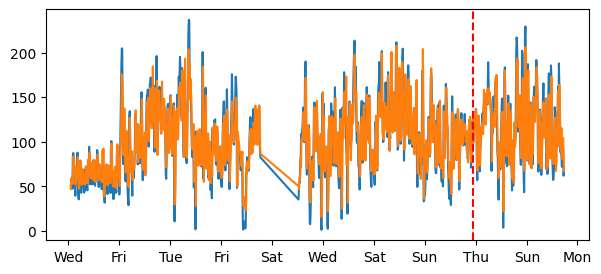

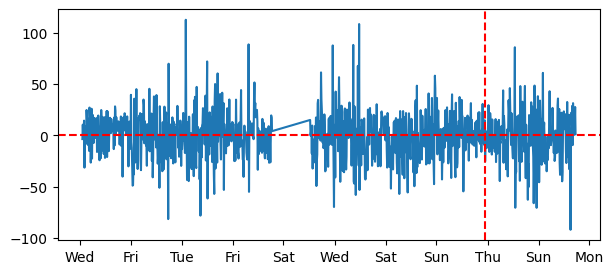

In [10]:
# Plot timeseries
fig = plt.figure(figsize=(7, 3))
x =  data.index
y1 = data['Forecast'] # Forecast
y2 = np.concatenate((y_train_lm, y_test_lm))
v = data.index[y_train_lm.shape[0]]
plt.plot(x, y1, label='actual')
plt.plot(x, y2, label='linear')
plt.axvline(x=v, color='r', linestyle='--')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a'))
plt.show()

# Plot residuals
fig = plt.figure(figsize=(7, 3))
x =  data.index
y1 = data['Forecast'] # Forecast
y2 = np.concatenate((y_train_lm, y_test_lm))
v = data.index[y_train_lm.shape[0]]
plt.plot(x, y2-y1, label='residuals')
plt.axvline(x=v, color='r', linestyle='--')
plt.axhline(y=0, color='r', linestyle='--')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a'))
plt.show()

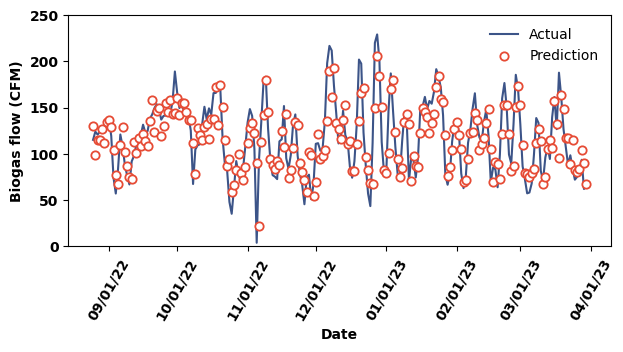

In [11]:
from matplotlib.font_manager import FontProperties

font_props = FontProperties(family='DejaVu Sans', weight='bold')

fig = plt.figure(figsize=(7, 3))

# Define the desired index range
start_index = 871
end_index = 1100

x = data.index[start_index:end_index]
y1 = data['Forecast'][start_index:end_index]  # Forecast
y2 = np.concatenate((y_train_lm, y_test_lm))[start_index:end_index]

plt.yticks(fontproperties=font_props)
plt.xticks(rotation=60,fontproperties=font_props)
plt.plot(x, y1, c='#3C5488FF', label='Actual',zorder=1)
plt.scatter(x,y2,marker='o', edgecolors='#E64B35FF', linewidths=1.3, facecolors='w', label='Prediction',zorder=2)
plt.xlabel('Date', fontproperties=font_props); plt.ylabel('Biogas flow (CFM)', fontproperties=font_props); 
plt.ylim(0, 250)  # Set y-axis limits
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D'))
plt.legend(frameon=False)

plt.show()


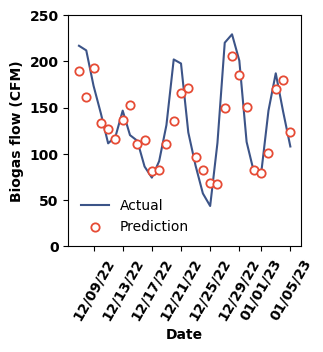

In [12]:
from matplotlib.font_manager import FontProperties

font_props = FontProperties(family='DejaVu Sans', weight='bold')

fig = plt.figure(figsize=(3, 3))

# Define the desired index range
start_index = 975
end_index = 1005

x = data.index[start_index:end_index]
y1 = data['Forecast'][start_index:end_index]  # Forecast
y2 = np.concatenate((y_train_lm, y_test_lm))[start_index:end_index]

plt.yticks(fontproperties=font_props)
plt.xticks(rotation=60,fontproperties=font_props)
plt.plot(x, y1, c='#3C5488FF', label='Actual',zorder=1)
plt.scatter(x,y2,marker='o', edgecolors='#E64B35FF', linewidths=1.3, facecolors='w', label='Prediction',zorder=2)
plt.xlabel('Date', fontproperties=font_props); plt.ylabel('Biogas flow (CFM)', fontproperties=font_props); 
plt.ylim(0, 250)  # Set y-axis limits
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D'))
plt.legend(frameon=False)

plt.show()


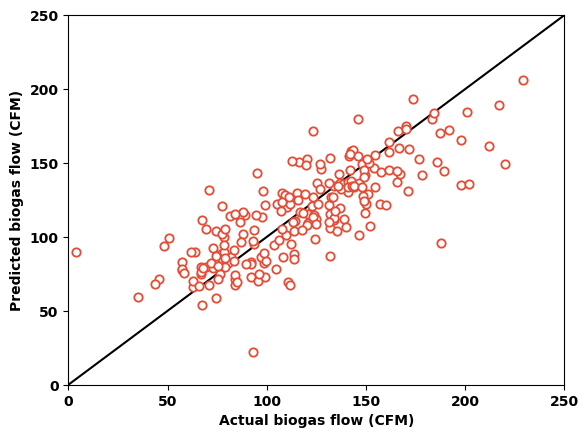

In [13]:
from matplotlib.font_manager import FontProperties

font_props = FontProperties(family='DejaVu Sans', weight='bold')
true_data = [0,250];
plt.plot(true_data, true_data, 'k',zorder=1)
# Plot the predicted values
plt.scatter(y_test, y_test_lm, marker='o', linewidths=1.3, edgecolors='#E64B35FF', facecolors='w', label = 'prediction',zorder=2)
plt.xticks(rotation=0, fontproperties=font_props)
plt.yticks(fontproperties=font_props)

# Graph labels
plt.xlabel('Actual biogas flow (CFM)', fontproperties=font_props)
plt.ylabel('Predicted biogas flow (CFM)', fontproperties=font_props)
plt.xlim(0, 250)  # Set x-axis limits
plt.ylim(0, 250)  # Set y-axis limits


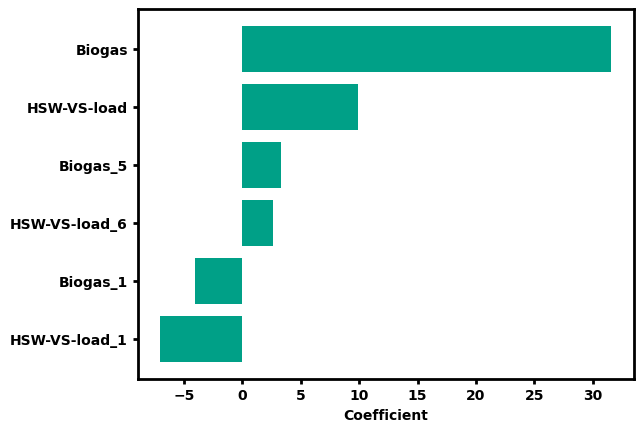

In [14]:
import numpy as np
import matplotlib.pyplot as plt

importance = model_lm.coef_
# Get the column names of x_test_s for the non-diurnal columns
column_names = x_test_s.columns[no_diurnal_cols]

# Sort the data based on importance values in ascending order
sorted_indices = np.argsort(importance)
sorted_importance = importance[sorted_indices]
sorted_column_names = column_names[sorted_indices]

# Create a horizontal bar chart
plt.barh(sorted_column_names, sorted_importance, color='#00A087FF')

plt.gca().xaxis.set_tick_params(width=2)
plt.gca().yaxis.set_tick_params(width=2)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)

# Add labels and title
plt.xlabel('Coefficient', fontproperties=font_props)
# Rotate x-axis labels for better readability
plt.xticks(fontproperties=font_props)
plt.yticks(fontproperties=font_props)
plt.savefig('FigS6.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

In [15]:
# Calculate training and testing error for the persistence model
mse_train_per = mean_squared_error(y_train, x_train['Biogas'])
r2_train_per = r2_score(y_train, x_train['Biogas'])
mse_test_per = mean_squared_error(y_test, x_test['Biogas'])
r2_test_per = r2_score(y_test, x_test['Biogas'])
mape_train_per = mean_absolute_percentage_error(y_train, x_train['Biogas'])
rmse_train = math.sqrt(mse_train_per)
mape_test_per = mean_absolute_percentage_error(y_test, x_test['Biogas'])
rmse_test = math.sqrt(mse_test_per)

# Print training and testing error for persistence
print(f"Training Mean Squared Error (MSE): {round(mse_train_per,3)}")
print(f"Training Root Mean Squared Error (MSE): {round(rmse_train,3)}")
print(f"Training Mean Absolute Percentage Error (MAPE): {round(mape_train_per,3)}")
print(f"Training R-squared (R2) Score: {round(r2_train_per,3)}")
print(f"Testing Mean Squared Error (MSE): {round(mse_test_per,3)}")
print(f"Testing Root Mean Squared Error (MSE): {round(rmse_test,3)}")
print(f"Testing Mean Absolute Percentage Error (MAPE): {round(mape_test_per,3)}")
print(f"Testing R-squared (R2) Score: {round(r2_test_per,3)}")

def adjusted_r2(r2, n, k):
    return 1 - ((1 - r2) * (n - 1)) / (n - k - 1)

n = len(x_test_s)  # Number of samples in test data
k = 1  # Number of predictors in the model

# Calculate Adjusted R-squared
adjusted_r2_value_per = adjusted_r2(r2_test_per, n, k)
print("Adjusted R-squared:", round(adjusted_r2_value_per,3))
print(k)
TEI = (mape_test_per*mape_test_per*rmse_test)/adjusted_r2_value_per
print("TEI:", round(TEI,3))

Training Mean Squared Error (MSE): 700.494
Training Root Mean Squared Error (MSE): 26.467
Training Mean Absolute Percentage Error (MAPE): 0.324
Training R-squared (R2) Score: 0.582
Testing Mean Squared Error (MSE): 894.622
Testing Root Mean Squared Error (MSE): 29.91
Testing Mean Absolute Percentage Error (MAPE): 0.329
Testing R-squared (R2) Score: 0.428
Adjusted R-squared: 0.426
1
TEI: 7.611
